In [1]:
import os

base_dir = 'Plant_Disease'
splits = ['Train/Train', 'Validation/Validation', 'Test/Test']

for split in splits:
    path = os.path.join(base_dir, split)
    print(f"\n📂 content {split}:")
    
    if os.path.exists(path):
        class_folders = os.listdir(path)
        for cls in class_folders:
            cls_path = os.path.join(path, cls)
            if os.path.isdir(cls_path):
                num_images = len([f for f in os.listdir(cls_path) if os.path.isfile(os.path.join(cls_path, f))])
                print(f"  └── {cls}: {num_images} image")
            else:
                print(f"  ⚠️ {cls_path} not folder.")
    else:
        print(f"❌ not found: {path}")



📂 content Train/Train:
  └── Healthy: 458 image
  └── Powdery: 430 image
  └── Rust: 434 image

📂 content Validation/Validation:
  └── Healthy: 20 image
  └── Powdery: 20 image
  └── Rust: 20 image

📂 content Test/Test:
  └── .ipynb_checkpoints: 0 image
  └── Healthy: 50 image
  └── Powdery: 50 image
  └── Rust: 50 image


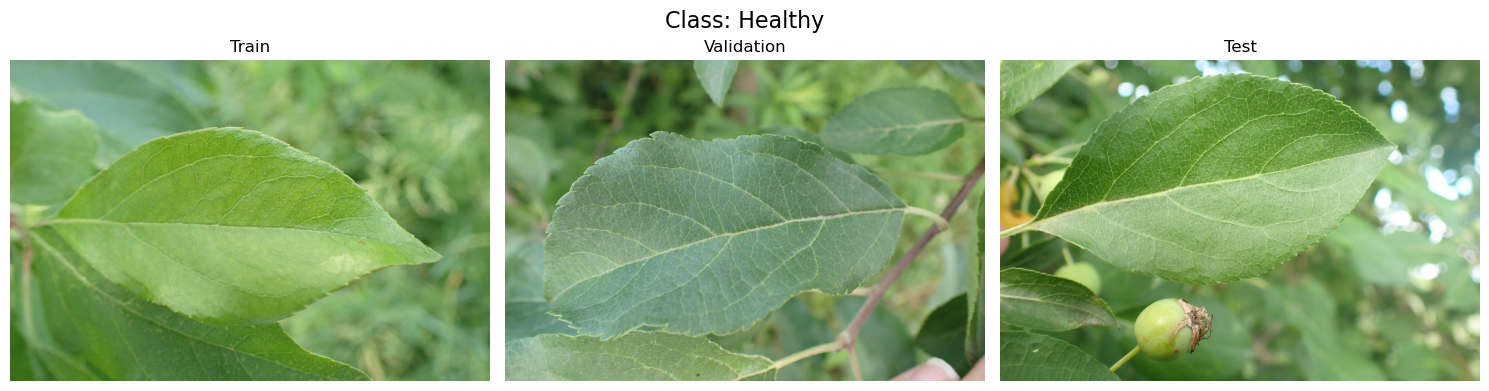

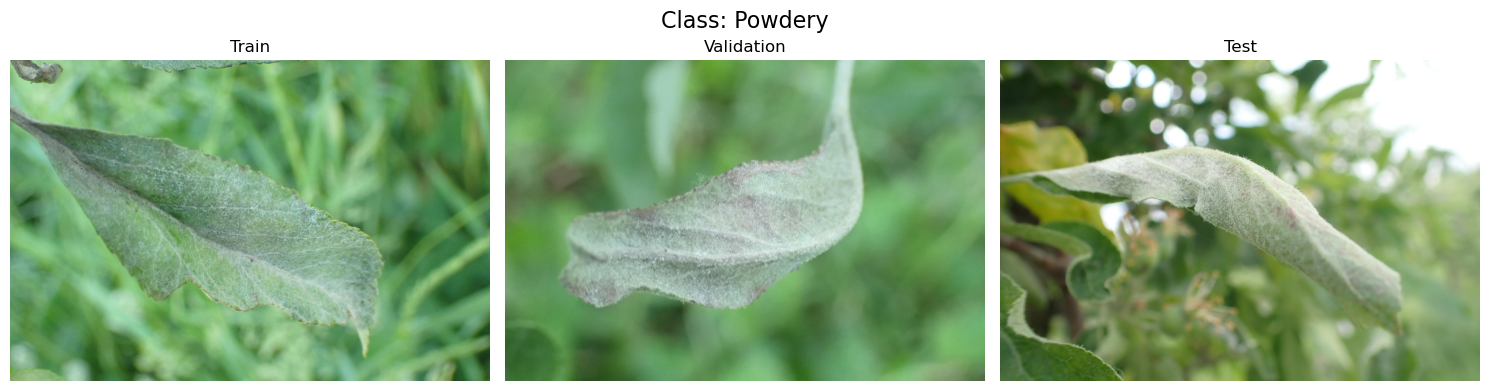

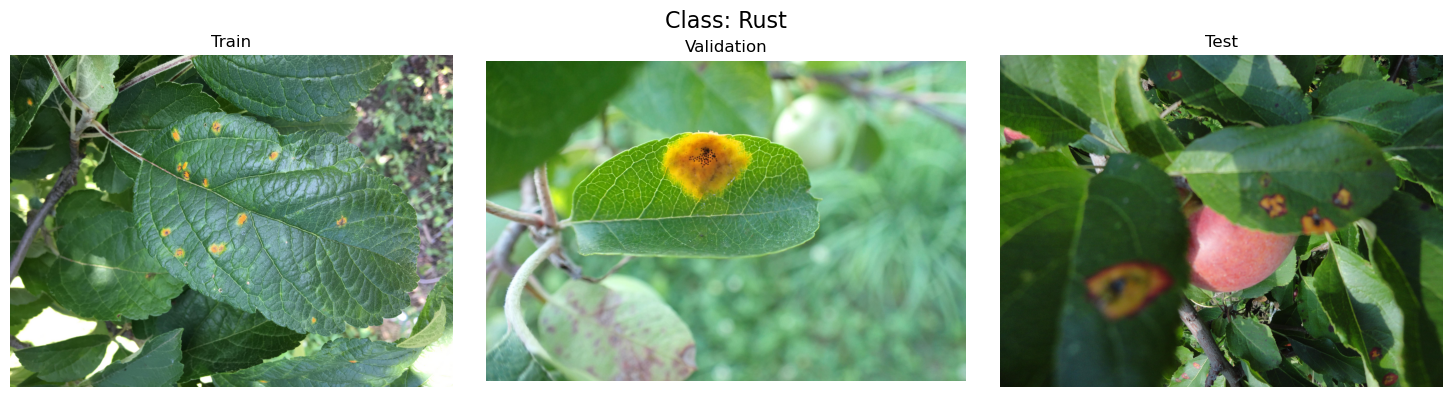

In [2]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

base_dirs = {
    'Train': 'Plant_Disease/Train/Train',
    'Validation': 'Plant_Disease/Validation/Validation',
    'Test': 'Plant_Disease/Test/Test'
}

for set_name, path in base_dirs.items():
    if not os.path.exists(path):
        print(f"❌ path is not found: {path}")

sample_class_names = os.listdir(base_dirs['Train'])

for class_name in sample_class_names:
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    fig.suptitle(f"Class: {class_name}", fontsize=16)

    for idx, (set_name, set_path) in enumerate(base_dirs.items()):
        class_folder = os.path.join(set_path, class_name)
        
        if os.path.isdir(class_folder):
            image_files = [f for f in os.listdir(class_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            
            if image_files:
                img_path = os.path.join(class_folder, random.choice(image_files))
                img = mpimg.imread(img_path)
                
                axes[idx].imshow(img)
                axes[idx].set_title(set_name)
                axes[idx].axis('off')
            else:
                axes[idx].set_title(f"{set_name}\n(no images)")
                axes[idx].axis('off')
        else:
            axes[idx].set_title(f"{set_name}\n(missing folder)")
            axes[idx].axis('off')

    plt.tight_layout()
    plt.show()


In [3]:
import os
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm


base_dir = "Plant_Disease"
datasets = {
    "train": os.path.join(base_dir, "Train", "Train"),
    "val": os.path.join(base_dir, "Validation", "Validation"),
    "test": os.path.join(base_dir, "Test", "Test"),
}

img_size = 224
valid_extensions = ('.jpg', '.jpeg', '.png')

data = {}

for split_name, split_path in datasets.items():
    images = []
    labels = []
    print(f"\n📦 Loading {split_name.upper()} dataset:")

    for label in os.listdir(split_path):
        class_path = os.path.join(split_path, label)
        if os.path.isdir(class_path):
            for file in tqdm(os.listdir(class_path), desc=f"⏳ {label}", leave=False):
                if file.lower().endswith(valid_extensions):
                    img_path = os.path.join(class_path, file)
                    try:
                        img = cv2.imread(img_path)
                        img = cv2.resize(img, (img_size, img_size))
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
                        images.append(img)
                        labels.append(label)
                    except:
                        print(f"❌ Failed: {img_path}")

    data[split_name] = {
        "images": np.array(images),
        "labels": np.array(labels)
    }

encoder = LabelEncoder()
data["train"]["labels_encoded"] = encoder.fit_transform(data["train"]["labels"])
data["val"]["labels_encoded"] = encoder.transform(data["val"]["labels"])
data["test"]["labels_encoded"] = encoder.transform(data["test"]["labels"])

for split in ['train', 'val', 'test']:
    data[split]["images"] = data[split]["images"].astype('float32') / 255.0

np.savez_compressed("planet_diseases_preprocessed.npz",
                    x_train=data["train"]["images"], y_train=data["train"]["labels_encoded"],
                    x_val=data["val"]["images"], y_val=data["val"]["labels_encoded"],
                    x_test=data["test"]["images"], y_test=data["test"]["labels_encoded"])

print("\n✅ Done preprocessing & saved to 'planet_diseases_preprocessed.npz'")
print(f"Classes: {encoder.classes_}")



📦 Loading TRAIN dataset:



📦 Loading VAL dataset:



📦 Loading TEST dataset:



✅ Done preprocessing & saved to 'planet_diseases_preprocessed.npz'
Classes: ['Healthy' 'Powdery' 'Rust']


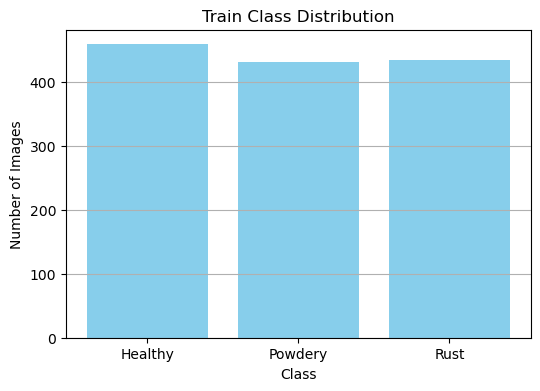

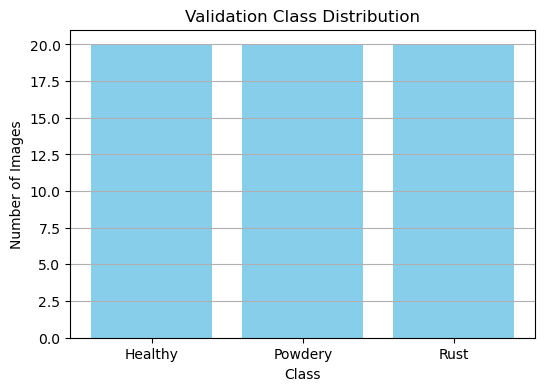

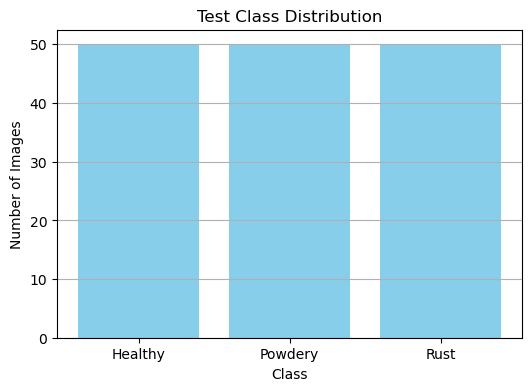

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

data = np.load('planet_diseases_preprocessed.npz')

y_train = data['y_train']
y_val = data['y_val']
y_test = data['y_test']

class_names = ['Healthy', 'Powdery', 'Rust']

def plot_distribution(y, title):
    counts = Counter(y)
    labels = list(counts.keys())
    values = [counts[i] for i in labels]
    names = [class_names[i] for i in labels]
    
    plt.figure(figsize=(6,4))
    plt.bar(names, values, color='skyblue')
    plt.title(f'{title} Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.grid(axis='y')
    plt.show()

plot_distribution(y_train, "Train")
plot_distribution(y_val, "Validation")
plot_distribution(y_test, "Test")


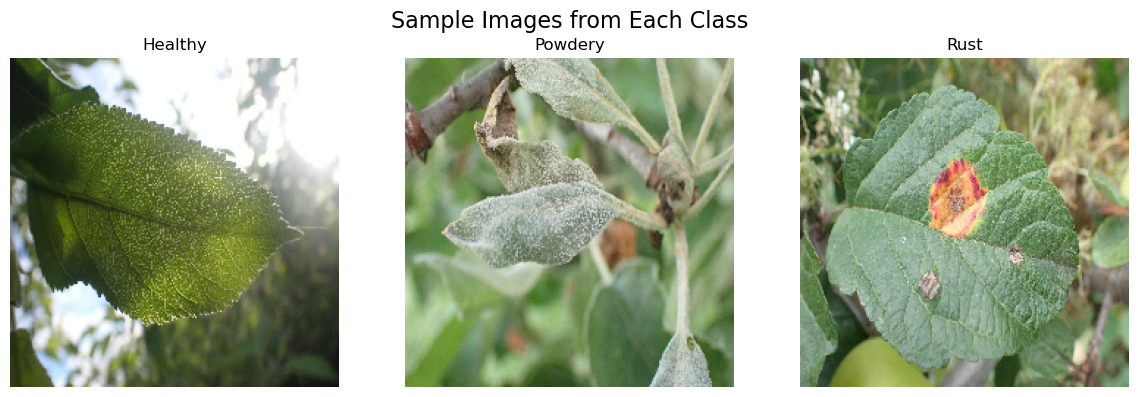

In [5]:
import random

x_train = data['x_train']
y_train = data['y_train']

def show_samples_per_class(x, y, class_names):
    plt.figure(figsize=(12,4))
    
    for class_id in range(len(class_names)):
        idxs = np.where(y == class_id)[0]
        random_idx = random.choice(idxs)
        img = x[random_idx]
        
        plt.subplot(1, 3, class_id+1)
        plt.imshow(img)
        plt.title(f"{class_names[class_id]}")
        plt.axis('off')
    
    plt.suptitle("Sample Images from Each Class", fontsize=16)
    plt.tight_layout()
    plt.show()

show_samples_per_class(x_train, y_train, class_names)


In [6]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from skimage.feature import hog, local_binary_pattern
from sklearn.preprocessing import LabelEncoder

base_path = "Plant_Disease/Train/Train/"  
X, y = [], []

classes = os.listdir(base_path)
print(f"[✔] Classes found: {classes}")

def extract_color_histogram(img, bins=(8, 8, 8)):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, bins,
                        [0, 180, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

def extract_features(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    hog_feat = hog(gray,
               orientations=9,
               pixels_per_cell=(16, 16),
               cells_per_block=(2, 2),
               block_norm='L2-Hys',
               visualize=False,
               feature_vector=True)


    lbp = local_binary_pattern(gray, P=8, R=1, method='uniform')
    (hist_lbp, _) = np.histogram(lbp.ravel(),
                                 bins=np.arange(0, 10),
                                 range=(0, 9))
    hist_lbp = hist_lbp.astype("float")
    hist_lbp /= (hist_lbp.sum() + 1e-6)

    color_hist = extract_color_histogram(img)

    return np.concatenate([hog_feat, hist_lbp, color_hist])

for class_name in classes:
    folder = os.path.join(base_path, class_name)
    if not os.path.isdir(folder):
        continue
    for filename in tqdm(os.listdir(folder), desc=f"Processing {class_name}"):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.resize(img, (224, 224))  # توحيد الحجم

        features = extract_features(img)
        X.append(features)
        y.append(class_name)

X = np.array(X)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)


print(f"[✔] Features shape: {X.shape}")
print(f"[✔] Labels shape: {y.shape}")


C:\Users\sheno\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
C:\Users\sheno\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
C:\Users\sheno\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


[✔] Classes found: ['Healthy', 'Powdery', 'Rust']


Processing Rust: 100%|██████████| 434/434 [01:15<00:00,  5.72it/s]

[✔] Features shape: (1322, 6605)
[✔] Labels shape: (1322,)


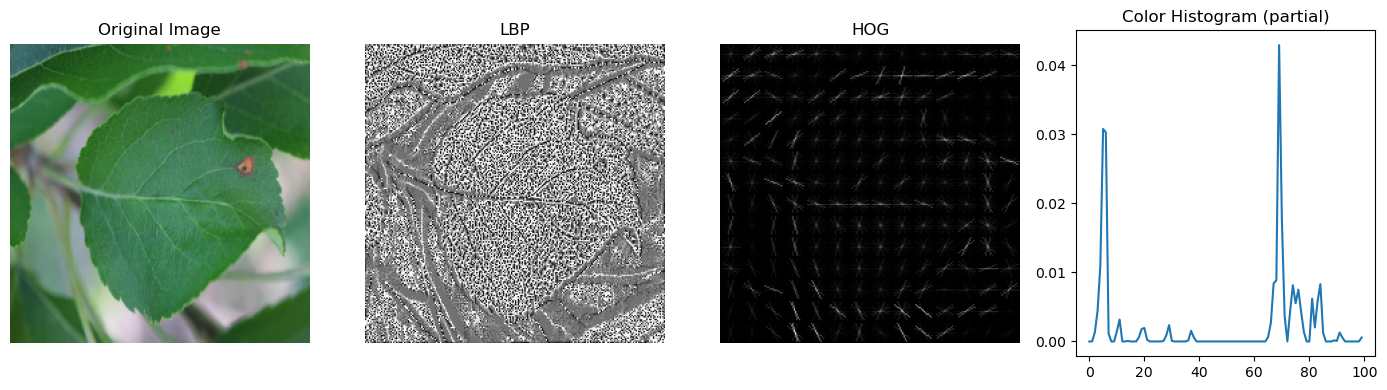

In [23]:
import matplotlib.pyplot as plt
from skimage.feature import hog, local_binary_pattern

sample_class = classes[2]  
sample_folder = os.path.join(base_path, sample_class)
sample_image_name = os.listdir(sample_folder)[0] 
sample_image_path = os.path.join(sample_folder, sample_image_name)

sample_img = cv2.imread(sample_image_path)
sample_img = cv2.resize(sample_img, (224, 224))
gray = cv2.cvtColor(sample_img, cv2.COLOR_BGR2GRAY)

hog_feat, hog_image = hog(
    gray,
    orientations=9,
    pixels_per_cell=(16, 16),
    cells_per_block=(2, 2),
    block_norm='L2-Hys',
    visualize=True,
    feature_vector=True
)

lbp_image = local_binary_pattern(gray, P=8, R=1, method='uniform')

color_hist = extract_color_histogram(sample_img)

plt.figure(figsize=(14, 4))

plt.subplot(1, 4, 1)
plt.imshow(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(lbp_image, cmap='gray')
plt.title("LBP")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(hog_image, cmap='gray')
plt.title("HOG")
plt.axis('off')

plt.subplot(1, 4, 4)
plt.plot(color_hist[:100]) 
plt.title("Color Histogram (partial)")

plt.tight_layout()
plt.show()


✅ RandomForest trained on full training set.

📊 Training Accuracy: 95.54%

📝 Training Classification Report:
              precision    recall  f1-score   support

     Healthy       0.92      0.97      0.94       458
     Powdery       0.96      0.95      0.95       430
        Rust       1.00      0.95      0.97       434

    accuracy                           0.96      1322
   macro avg       0.96      0.96      0.96      1322
weighted avg       0.96      0.96      0.96      1322



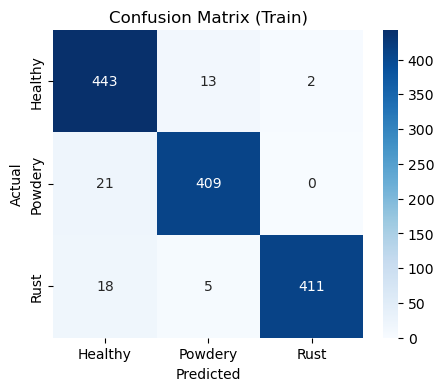

Processing .ipynb_checkpoints: 0it [00:00, ?it/s]
Processing Rust: 100%|██████████| 50/50 [00:09<00:00,  5.33it/s]



📊 Test Accuracy: 90.67%

📝 Test Classification Report:
              precision    recall  f1-score   support

     Healthy       0.85      0.90      0.87        50
     Powdery       0.90      0.90      0.90        50
        Rust       0.98      0.92      0.95        50

    accuracy                           0.91       150
   macro avg       0.91      0.91      0.91       150
weighted avg       0.91      0.91      0.91       150



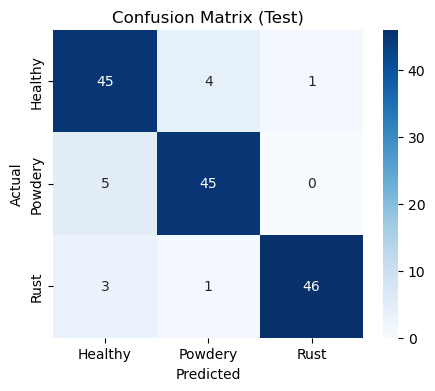

In [7]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt

rf_model = RandomForestClassifier(n_estimators=266,
    max_depth=4,
    min_samples_split=6,
    min_samples_leaf=2,
    random_state=42)

rf_model.fit(X, y)
print("✅ RandomForest trained on full training set.\n")

y_train_pred = rf_model.predict(X)
train_acc = accuracy_score(y, y_train_pred)
print(f"📊 Training Accuracy: {train_acc*100:.2f}%")
print("\n📝 Training Classification Report:")
print(classification_report(y, y_train_pred, target_names=label_encoder.classes_))

plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y, y_train_pred),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix (Train)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


test_path = "Plant_Disease/Test/Test/"
test_X, test_y = [], []

for class_name in os.listdir(test_path):
    class_folder = os.path.join(test_path, class_name)
    if not os.path.isdir(class_folder): 
        continue
    for fname in tqdm(os.listdir(class_folder), desc=f"Processing {class_name}"):
        img = cv2.imread(os.path.join(class_folder, fname))
        if img is None: 
            continue
        img = cv2.resize(img, (224, 224))
        feats = extract_features(img)      
        test_X.append(feats)
        test_y.append(class_name)

test_X = np.array(test_X)
test_y_enc = label_encoder.transform(test_y)


y_test_pred = rf_model.predict(test_X)
test_acc = accuracy_score(test_y_enc, y_test_pred)
print(f"\n📊 Test Accuracy: {test_acc*100:.2f}%")
print("\n📝 Test Classification Report:")
print(classification_report(test_y_enc, y_test_pred, target_names=label_encoder.classes_))

plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(test_y_enc, y_test_pred),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


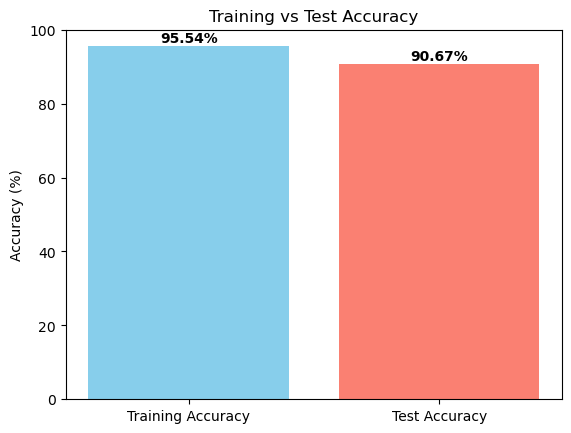

In [10]:
import matplotlib.pyplot as plt

train_acc = 95.54
test_acc = 90.67

labels = ['Training Accuracy', 'Test Accuracy']
values = [train_acc, test_acc]

plt.bar(labels, values, color=['skyblue', 'salmon'])
plt.ylim(0, 100) 

for i, v in enumerate(values):
    plt.text(i, v + 1, f"{v:.2f}%", ha='center', fontweight='bold')

plt.title('Training vs Test Accuracy')
plt.ylabel('Accuracy (%)')
plt.show()


In [17]:
import pickle

model_filename = 'rf_plant_disease_model.pkl'

with open(model_filename, 'wb') as file:
    pickle.dump(rf_model, file)

print(f"✅ Model saved successfully as '{model_filename}'")


✅ Model saved successfully as 'rf_plant_disease_model.pkl'
